## Churn Prediction Assessment - Training And Selecting The Final Model

#### **Context**

We are going to run a set of baseline classification models to determine which one is the most suitable and best performing. Once the best candidate is identified, we will refine and optimize it in further notebooks.

The primary evaluation metric will be the ROC AUC score, since it provides a more reliable measure of performance when dealing with imbalanced datasets by considering the trade-off between true positive rate and false positive rate across all thresholds.

Additionally, in our churn prediction problem, the priority is to minimize cases where the model fails to predict churn but the customer actually leaves (i.e., reducing false negatives). Therefore, the most important metric is Recall for the positive class (churn). This ensures the model captures the majority of churners, even if it means occasionally misclassifying some non-churners as churners (favoring false positives over false negatives).

For completeness, we will also report accuracy, but it may not be as informative in this context, as a model could achieve high accuracy simply by predicting the majority class (non-churn) while failing to detect churn cases.

#### **Stratified k-Fold Cross Validation**

We will evaluate Logistic Regression, Random Forest, AdaBoost, and XGBoost using Stratified k-Fold Cross Validation to identify the model best suited for predicting customer churn.

Cross Validation is important because it allows us to train and validate each model multiple times on different splits of the data. Instead of relying on a single train-test split, the dataset is divided into k folds, and the process is repeated so that every observation is used for both training and validation. The results are then averaged, giving us more reliable performance metrics.

We use the stratified version of k-Fold to ensure that the proportion of churners and non-churners is preserved in every fold. This is especially important for imbalanced datasets as this one, as it prevents the models from being biased toward the majority class.

By averaging metrics such as ROC AUC, Recall, and Accuracy across folds, we can make a fair comparison between models and select the one that generalizes best to new data.

#### **Feature Selection and Train/Test Split (Stratified k-Fold)**

In [67]:
# Import required libraries
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_curve, auc, confusion_matrix

In [ ]:
# Read parquet
df = pd.read_parquet("../data/processed/churn_prediction_dataset.parquet")
df.head()

,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_anual,mcomisiones,mactivos_margen,mpasivos_margen,cant_total_prod,...,visa_mconsumototal,visa_cconsumos,visa_mpagominimo,clase_binaria,visa_tenure_days,tcuentas_2,visa_cuenta_estado_11.0,visa_cuenta_estado_12.0,visa_cuenta_estado_19.0,visa_cuenta_estado_0.0
0,0,1,44,72,3296.69,14455.27,579.66,910.65,1411.60,11,...,14555.47,13.0,3837.6,0,4473.0,False,False,False,False,False
1,0,0,78,159,1032.18,10141.18,790.58,71.21,135.29,6,...,-11.55,2.0,35.1,0,7129.0,False,False,False,False,False
2,0,1,64,299,-52.34,4752.64,236.08,-422.18,175.66,7,...,6788.67,4.0,1977.3,0,10584.0,False,False,False,False,False
3,0,1,48,282,485.91,10676.87,1280.47,-1275.18,596.07,8,...,2946.70,5.0,573.3,0,3848.0,False,False,False,False,False
4,0,1,45,171,5878.27,24298.75,64.38,22.11,4947.03,9,...,1048.32,1.0,128.7,0,7501.0,False,False,False,False,False


In [9]:
# Separate 'clase_binaria' as the target vector (y) and use the remaining columns as the feature matrix (X)
y = df['clase_binaria']
X = df.drop(columns = ['clase_binaria'])

In [10]:
# Set up stratified 5-fold cross-validation (no separate train/test split needed)
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 12)

In [68]:
# We'll run a line in order to avoid convergence warnings from our models
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore convergence warnings
warnings.filterwarnings("ignore", category = ConvergenceWarning)

#### **Logistic Regression**

##### Model Training (Definition)

In [12]:
# Initialize Logistic Regression model with class balancing
log_reg = LogisticRegression(class_weight = 'balanced', max_iter = 1000, random_state = 12)

##### Model Validation

In [13]:
# Calculate the ROC AUC
roc_auc_scores = cross_val_score(log_reg, X, y, cv = cv, scoring = 'roc_auc')

# Calculate the Accuracy
accuracy_scores = cross_val_score(log_reg, X, y, cv = cv, scoring = make_scorer(accuracy_score))

# Calculate the Recall
recall_scores = cross_val_score(log_reg, X, y, cv = cv, scoring = make_scorer(recall_score, pos_label = 1))

# Calculate the Precision
precision_scores = cross_val_score(log_reg, X, y, cv = cv, scoring = make_scorer(precision_score, pos_label = 1))

# Calculate the F1-Score
f1_scores = cross_val_score(log_reg, X, y, cv = cv, scoring = make_scorer(f1_score, pos_label = 1))

# Print the results
print(f"ROC AUC - Mean: {roc_auc_scores.mean():.3f}, Std: {roc_auc_scores.std():.3f}")
print(f"Accuracy - Mean: {accuracy_scores.mean():.3f}, Std: {accuracy_scores.std():.3f}")
print(f"Recall - Mean: {recall_scores.mean():.3f}, Std: {recall_scores.std():.3f}")
print(f"Precision - Mean: {precision_scores.mean():.3f}, Std: {precision_scores.std():.3f}")
print(f"F1-Score - Mean: {f1_scores.mean():.3f}, Std: {f1_scores.std():.3f}")

ROC AUC - Mean: 0.865, Std: 0.008
Accuracy - Mean: 0.799, Std: 0.003
Recall - Mean: 0.829, Std: 0.024
Precision - Mean: 0.043, Std: 0.002
F1-Score - Mean: 0.081, Std: 0.003


##### Results (Average 5 Folds)

ROC AUC - Mean: 0.867, Std: 0.007

Accuracy - Mean: 0.801, Std: 0.006

Recall - Mean: 0.829, Std: 0.025

Precision - Mean: 0.043, Std: 0.001

F1-Score - Mean: 0.082, Std: 0.002

#### **Random Forest**

##### Model Training (Definition)

In [14]:
# Initialize the Random Forest model with class balancing
random_forest = RandomForestClassifier(class_weight = 'balanced', n_estimators = 100, random_state = 12)

##### Model Validation

In [15]:
# Calculate the ROC AUC
roc_auc_scores = cross_val_score(random_forest, X, y, cv = cv, scoring = 'roc_auc')

# Calculate the Accuracy
accuracy_scores = cross_val_score(random_forest, X, y, cv = cv, scoring = make_scorer(accuracy_score))

# Calculate the Recall
recall_scores = cross_val_score(random_forest, X, y, cv = cv, scoring = make_scorer(recall_score, pos_label = 1))

# Calculate the Precision
precision_scores = cross_val_score(random_forest, X, y, cv = cv, scoring = make_scorer(precision_score, pos_label = 1))

# Calculate the F1-Score
f1_scores = cross_val_score(random_forest, X, y, cv = cv, scoring = make_scorer(f1_score, pos_label = 1))

# Print the results
print(f"ROC AUC - Mean: {roc_auc_scores.mean():.3f}, Std: {roc_auc_scores.std():.3f}")
print(f"Accuracy - Mean: {accuracy_scores.mean():.3f}, Std: {accuracy_scores.std():.3f}")
print(f"Recall - Mean: {recall_scores.mean():.3f}, Std: {recall_scores.std():.3f}")
print(f"Precision - Mean: {precision_scores.mean():.3f}, Std: {precision_scores.std():.3f}")
print(f"F1-Score - Mean: {f1_scores.mean():.3f}, Std: {f1_scores.std():.3f}")

ROC AUC - Mean: 0.910, Std: 0.006
Accuracy - Mean: 0.992, Std: 0.000
Recall - Mean: 0.268, Std: 0.015
Precision - Mean: 0.844, Std: 0.029
F1-Score - Mean: 0.406, Std: 0.018


##### Results (Average 5 Folds)

ROC AUC - Mean: 0.910, Std: 0.006

Accuracy - Mean: 0.992, Std: 0.000

Recall - Mean: 0.268, Std: 0.015

Precision - Mean: 0.844, Std: 0.029

F1-Score - Mean: 0.406, Std: 0.018

#### **AdaBoost**

##### Model Training (Definition)

In [16]:
# Define the AdaBoost model with the base learner
ada_model = AdaBoostClassifier(n_estimators = 100, random_state = 12)

##### Model Validation

In [17]:
# Calculate the ROC AUC
roc_auc_scores = cross_val_score(ada_model, X, y, cv = cv, scoring = 'roc_auc')

# Calculate the Accuracy
accuracy_scores = cross_val_score(ada_model, X, y, cv = cv, scoring = make_scorer(accuracy_score))

# Calculate the Recall
recall_scores = cross_val_score(ada_model, X, y, cv = cv, scoring = make_scorer(recall_score, pos_label = 1))

# Calculate the Precision
precision_scores = cross_val_score(ada_model, X, y, cv = cv, scoring = make_scorer(precision_score, pos_label = 1))

# Calculate the F1-Score
f1_scores = cross_val_score(ada_model, X, y, cv = cv, scoring = make_scorer(f1_score, pos_label = 1))

# Print the results
print(f"ROC AUC - Mean: {roc_auc_scores.mean():.3f}, Std: {roc_auc_scores.std():.3f}")
print(f"Accuracy - Mean: {accuracy_scores.mean():.3f}, Std: {accuracy_scores.std():.3f}")
print(f"Recall - Mean: {recall_scores.mean():.3f}, Std: {recall_scores.std():.3f}")
print(f"Precision - Mean: {precision_scores.mean():.3f}, Std: {precision_scores.std():.3f}")
print(f"F1-Score - Mean: {f1_scores.mean():.3f}, Std: {f1_scores.std():.3f}")

ROC AUC - Mean: 0.939, Std: 0.007
Accuracy - Mean: 0.991, Std: 0.000
Recall - Mean: 0.265, Std: 0.015
Precision - Mean: 0.709, Std: 0.015
F1-Score - Mean: 0.386, Std: 0.015


##### Results (Average 5 Folds)

ROC AUC - Mean: 0.939, Std: 0.007

Accuracy - Mean: 0.991, Std: 0.000

Recall - Mean: 0.265, Std: 0.015

Precision - Mean: 0.709, Std: 0.015

F1-Score - Mean: 0.386, Std: 0.015

#### **XGBoost**

##### Model Training (Definition)

In [26]:
# Inicializo el modelo de Boosting con Gradient Boosting
xg_boosting = xgb.XGBClassifier(random_state = 12)

##### Model Validation

In [19]:
# Calculate ROC AUC
roc_auc_scores = cross_val_score(xg_boosting, X, y, cv = cv, scoring = 'roc_auc')

# Calculate Accuracy
accuracy_scores = cross_val_score(xg_boosting, X, y, cv = cv, scoring = make_scorer(accuracy_score))

# Calculate Recall
recall_scores = cross_val_score(xg_boosting, X, y, cv = cv, scoring = make_scorer(recall_score, pos_label = 1))

# Calculate Precision
precision_scores = cross_val_score(xg_boosting, X, y, cv = cv, scoring = make_scorer(precision_score, pos_label = 1))

# Calculate F1-Score
f1_scores = cross_val_score(xg_boosting, X, y, cv = cv, scoring = make_scorer(f1_score, pos_label = 1))

# Print the results
print(f"ROC AUC - Mean: {roc_auc_scores.mean():.3f}, Std: {roc_auc_scores.std():.3f}")
print(f"Accuracy - Mean: {accuracy_scores.mean():.3f}, Std: {accuracy_scores.std():.3f}")
print(f"Recall - Mean: {recall_scores.mean():.3f}, Std: {recall_scores.std():.3f}")
print(f"Precision - Mean: {precision_scores.mean():.3f}, Std: {precision_scores.std():.3f}")
print(f"F1-Score - Mean: {f1_scores.mean():.3f}, Std: {f1_scores.std():.3f}")

ROC AUC - Mean: 0.935, Std: 0.009
Accuracy - Mean: 0.992, Std: 0.000
Recall - Mean: 0.376, Std: 0.023
Precision - Mean: 0.725, Std: 0.013
F1-Score - Mean: 0.495, Std: 0.019


##### Results (Average 5 Folds)

ROC AUC - Mean: 0.935, Std: 0.009

Accuracy - Mean: 0.992, Std: 0.000

Recall - Mean: 0.376, Std: 0.023

Precision - Mean: 0.725, Std: 0.013

F1-Score - Mean: 0.495, Std: 0.019

#### **Final Model Selection**

All models deliver competitive performance, but the tree-based ensemble methods clearly outperform Logistic Regression in terms of ROC AUC, which is our primary metric for model quality. Both AdaBoost (0.939) and XGBoost (0.935) achieve excellent discrimination power, well above Logistic Regression (0.867).

Between these, XGBoost strikes the best balance: while its Recall (0.376) is lower than Logistic Regression, it is meaningfully higher than both Random Forest (0.268) and AdaBoost (0.265). This means XGBoost not only maintains state-of-the-art ROC AUC, but also recovers more churners than the other ensemble approaches.

From a business perspective, this makes XGBoost the most suitable choice. It maximizes our ability to separate churners from non-churners with high confidence, while offering more acceptable Recall levels than other high-performing models. Precision and F1 are secondary in this context, but XGBoost also shows a healthier trade-off here.

#### **Feature Importance**

In this section, we use SHAP (SHapley Additive exPlanations) to interpret an XGBoost model. SHAP helps us explain the contribution of each feature to individual predictions and to the model overall. By analyzing SHAP values, we can see which features most influence the outcome, whether their effect is positive or negative, and how they interact across the dataset. This gives us greater transparency and interpretability beyond raw feature importance.

Although this will not be our final XGBoost model—since we will later dedicate a full section to model refinement and hyperparameter tuning—we train it on the entire dataset here to preview the SHAP analysis. The goal at this stage is not to optimize performance, but to explore feature importance and gain an initial understanding of which variables drive predictions and how the model makes both good and bad decisions.

##### Set-Up

In [44]:
# Import library
import shap

In [ ]:
# Create a SHAP-friendly copy of X and convert all boolean columns to 0/1 integers
# Tree-based SHAP expects numeric inputs; casting True/False to 0/1 avoids dtype issues and keeps explanations consistent
X_shap = X.copy()
bool_cols = X_shap.select_dtypes(include = ['bool', 'boolean']).columns
if len(bool_cols) > 0:
    X_shap[bool_cols] = X_shap[bool_cols].astype('int64')

In [48]:
# Train the model once
# It's a new model an all our observations, as mentioned before
xg_boosting.fit(X_shap, y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [49]:
# Build ONE explainer on the FULL dataset (fixes a single global E[f(X)])
explainer = shap.Explainer(xg_boosting, X_shap) # raw log-odds output (recommended)
sv_all = explainer(X_shap) # compute once for ALL rows

100%|===================| 170435/170722 [06:25<00:00]        

##### Violin Plot 

The SHAP violin plot shows how each feature impacts the model’s predictions, with features ordered by their overall importance (average absolute SHAP value). The horizontal axis represents the SHAP values: negative values decrease the prediction while positive values increase it. The color indicates the original feature value, where blue corresponds to low values and red to high values. This visualization makes it easy to see which features matter most and how their values influence the model’s output.

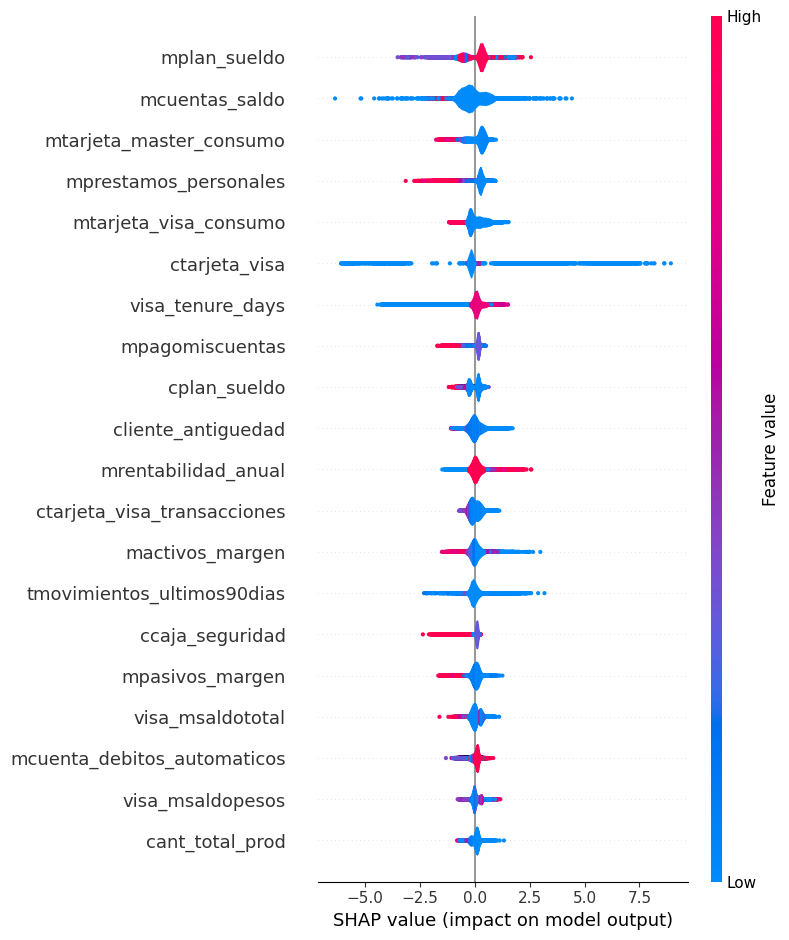

In [ ]:
# Global summary (violin) using the SAME explanations and SAME data used to build the explainer
shap.summary_plot(sv_all, X_shap, plot_type = "violin", max_display = 20)

Top 5 most important features:

* mplan_sueldo (salary credited) → Higher ⇒ more churn risk. Likely “salary-only” users or people moving primary banking elsewhere.
* mcuentas_saldo (total balance) → Lower ⇒ more churn risk. Low liquidity = low attachment; easy to leave.
* mtarjeta_master_consumo (MC spend) → Higher ⇒ more churn risk. Reward/promo chasers or multi-bank users.
* mprestamos_personales (outstanding personal loan) → Higher ⇒ less churn risk. Loans anchor clients (auto-debits, switching costs).
* mtarjeta_visa_consumo (VISA spend) → Higher ⇒ more churn risk. Same intuition as MC (active, mobile cardholders).

##### Waterfall Plots

In this section we move from the global view to local explanations. Using the same SHAP object (single global baseline E[f(X)] computed on the full dataset), each waterfall plot decomposes one prediction: red bars push the score toward churn, blue bars push toward non-churn; the bars sum to the final f(x), which maps to a probability via the sigmoid function.

We show three focused views:

1. True Positive (TP) — one correctly predicted churner. We highlight the features that pushed f(x) above zero and explain why the model was confident about churn.

2. True Negative (TN) — one correctly predicted non-churner. We show the stabilizing features that pulled f(x) further below zero.

3. False Negatives (FN) — ten missed churners (our most costly errors). For each case, we analyze the feature pushes/pulls to identify recurring patterns behind the misclassification and derive actionables (feature engineering, thresholding, calibration).

In [53]:
# Predict once on the SAME matrix used for SHAP (X_shap)
y_prob = xg_boosting.predict_proba(X_shap)[:, 1]  # positive-class probability
y_pred = (y_prob >= 0.5).astype(int)              # class labels

# (sanity check: lengths must match)
assert len(y_prob) == len(X_shap) == sv_all.values.shape[0]

In [54]:
# Confusion matrix (to see counts of TP/TN/FP/FN)
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(f"                Predicted No   Predicted Yes")
print(f"Actual No     TN = {cm[0,0]}    FP = {cm[0,1]}")
print(f"Actual Yes    FN = {cm[1,0]}    TP = {cm[1,1]}")

Confusion Matrix:
                Predicted No   Predicted Yes
Actual No     TN = 168825    FP = 62
Actual Yes    FN = 680    TP = 1155


In [58]:
# Build a small helper table (optional, just convenience)
results_df = pd.DataFrame({
    "true_label": np.asarray(y),
    "predicted_label": y_pred,
    "probability": y_prob
})

# Pick a representative row for each case (first match)
tp_row = results_df[(results_df.true_label == 1) & (results_df.predicted_label == 1)].iloc[0]
tn_row = results_df[(results_df.true_label == 0) & (results_df.predicted_label == 0)].iloc[0]
fp_row = results_df[(results_df.true_label == 0) & (results_df.predicted_label == 1)].iloc[0]
fn_row = results_df[(results_df.true_label == 1) & (results_df.predicted_label == 0)].iloc[0]

# Row indices we will explain (these are positions in X_shap / sv_all)
tp_index = tp_row.name
tn_index = tn_row.name
fp_index = fp_row.name
fn_index = fn_row.name

# Quick verification
print("Churn: 1 - No churn: 0")
print(f"TP → y = {y.iloc[tp_index]}, pred = {y_pred[tp_index]}, p = {y_prob[tp_index]:.3f}")
print(f"TN → y = {y.iloc[tn_index]}, pred = {y_pred[tn_index]}, p = {y_prob[tn_index]:.3f}")
print(f"FP → y = {y.iloc[fp_index]}, pred = {y_pred[fp_index]}, p = {y_prob[fp_index]:.3f}")
print(f"FN → y = {y.iloc[fn_index]}, pred = {y_pred[fn_index]}, p = {y_prob[fn_index]:.3f}")

Churn: 1 - No churn: 0
TP → y = 1, pred = 1, p = 0.665
TN → y = 0, pred = 0, p = 0.000
FP → y = 0, pred = 1, p = 0.611
FN → y = 1, pred = 0, p = 0.454


**True Positive Case**

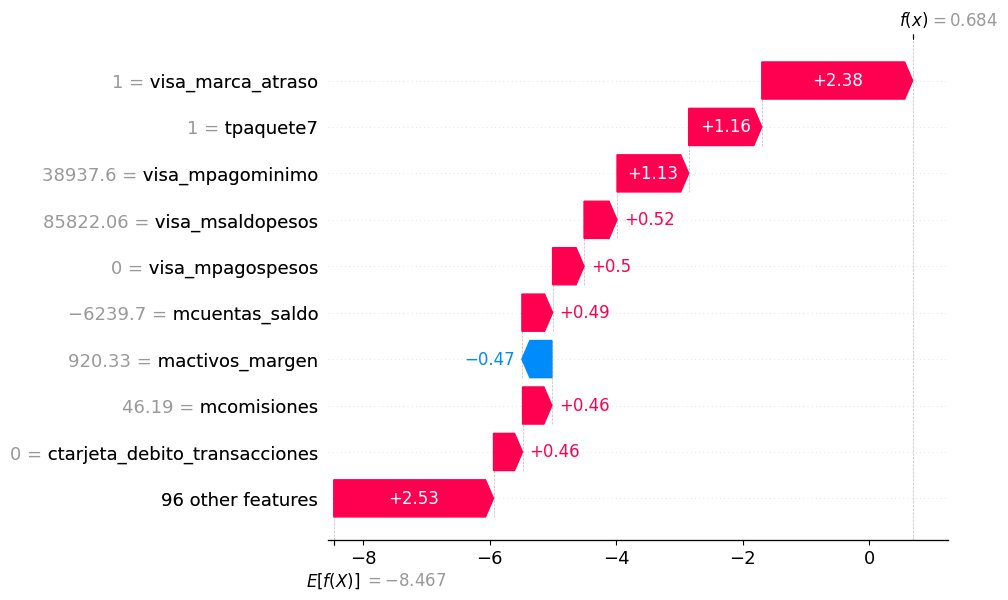

In [ ]:
# TP waterfall (bars sum from global E[f(X)] to f(x); sigmoid(f(x)) ≈ probability)
shap.waterfall_plot(sv_all[tp_index], max_display = 10, show = True)

TP waterfall — starts at the global baseline E[f(X)] = −8.467.
Most customers are non-churn, so explanations begin far below zero and then add each feature’s push/pull.

Key drivers (sum to f(x) = 0.684 → p ≈ 0.664):

* visa_marca_atraso = 1 and a low-value package (7) → strong red pushes (payment stress + fee pain → higher churn risk).
* High credit use (e.g., visa_mpagominimo, visa_msaldopesos, visa_mpagospos) and low/negative balance (mcuentas_saldo) → more red pressure.
* Higher assets (mactivos_margen) → blue pull that stabilizes slightly but can’t offset the red signals. 
* Net: contributions add up to a positive score → correct churn (True Positive).

**True Negative Case**

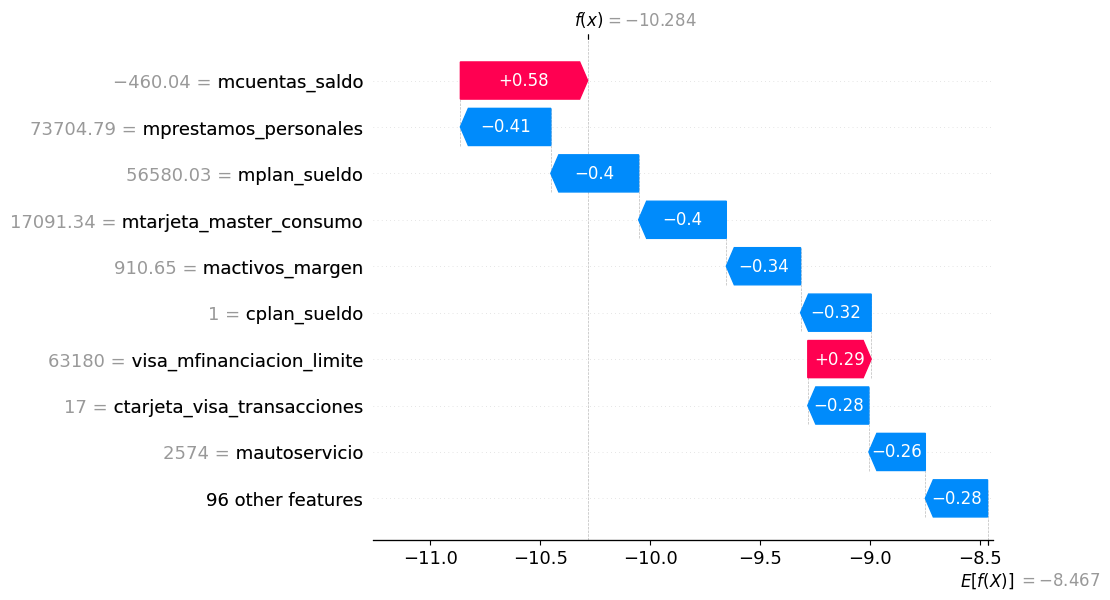

In [ ]:
# TN waterfall
shap.waterfall_plot(sv_all[tn_index], max_display = 10, show = True)

TN waterfall — contributions sum to f(x) = −10.284 (very low churn probability).

Key drivers:

* Big blue pulls from strong relationship/engagement signals (steady activity, products in use, assets, routine interactions) drag risk down hard.
* A couple of small red pushes hint at mild risk (tighter liquidity or higher exposure), but they’re too weak.
* Net: blues overwhelm reds, the score stays far below zero → correct non-churn (True Negative).

**False Negative Cases**

We focus on the missed churners (actual = 1, predicted = 0). Each waterfall uses the same SHAP object (single global baseline) and shows how red (↑ churn) and blue (↓ churn) contributions summed to a negative f(x) → probability < 0.5 → predicted non-churn.

In [59]:
# Indices of False Negatives (actual=1, predicted=0)
fn_idx_all = [i for i in range(len(y)) if (y.iloc[i] == 1 and y_pred[i] == 0)]

In [64]:
# Import libraries
import random
import math

In [ ]:
# Take up to 10 (reproducible sample)
random.seed(12)
fn_idx = random.sample(fn_idx_all, k = min(10, len(fn_idx_all)))

[FN 1] idx=139081 | f(x)=-1.957 → p=0.124 | true=1 pred=0


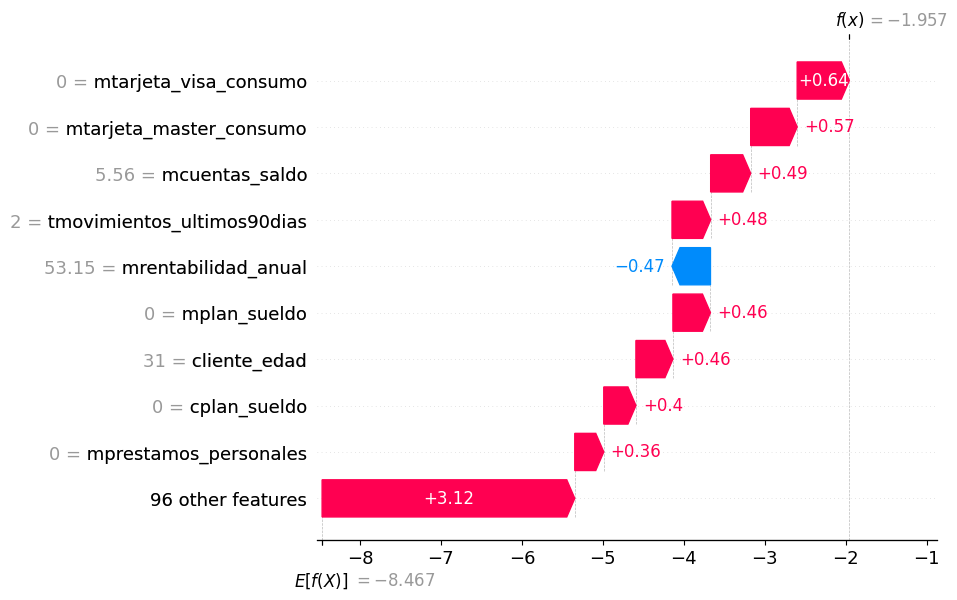

[FN 2] idx=84768 | f(x)=-1.506 → p=0.182 | true=1 pred=0


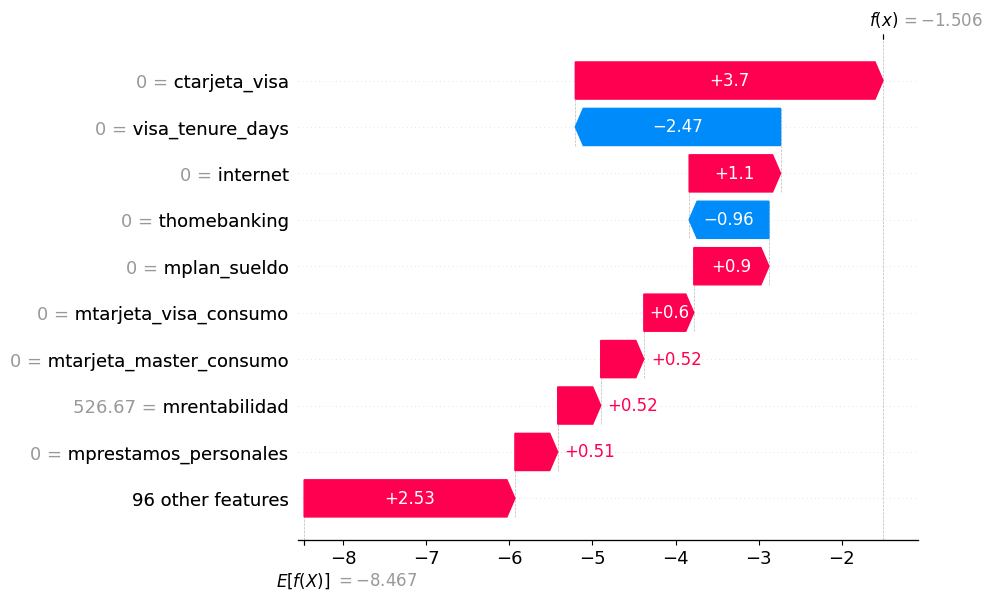

[FN 3] idx=170106 | f(x)=-1.831 → p=0.138 | true=1 pred=0


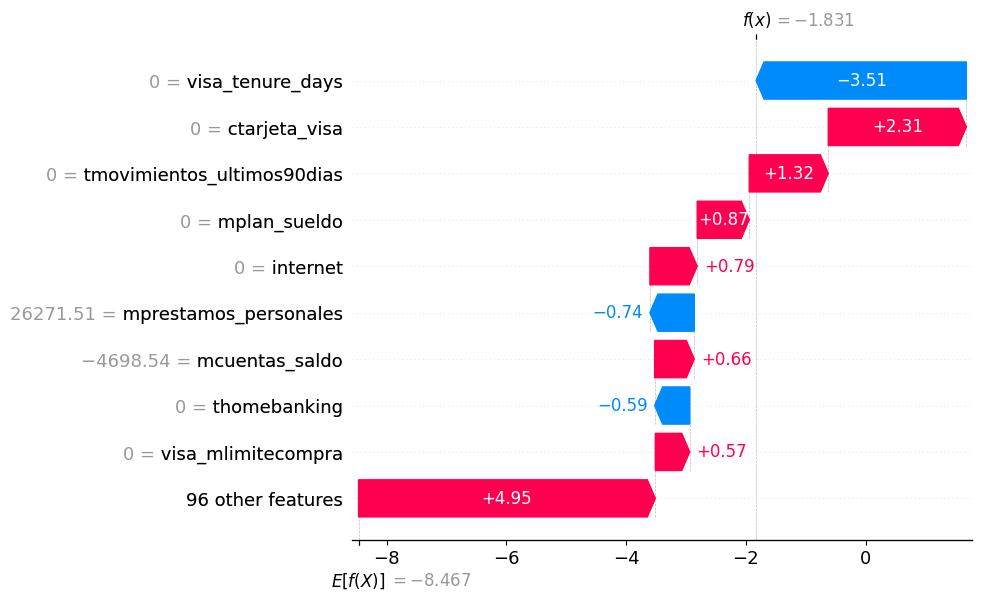

[FN 4] idx=151511 | f(x)=-1.401 → p=0.198 | true=1 pred=0


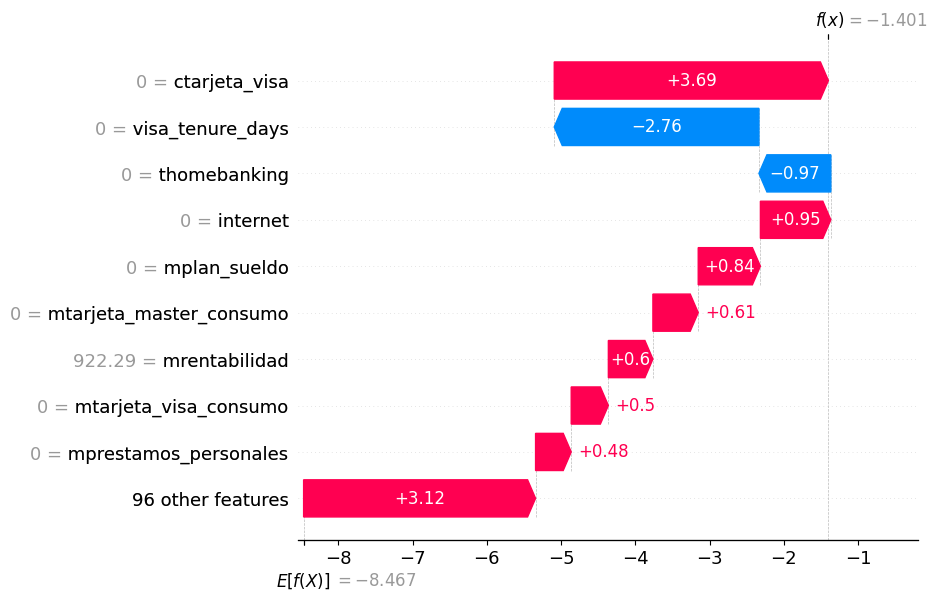

[FN 5] idx=103911 | f(x)=-1.809 → p=0.141 | true=1 pred=0


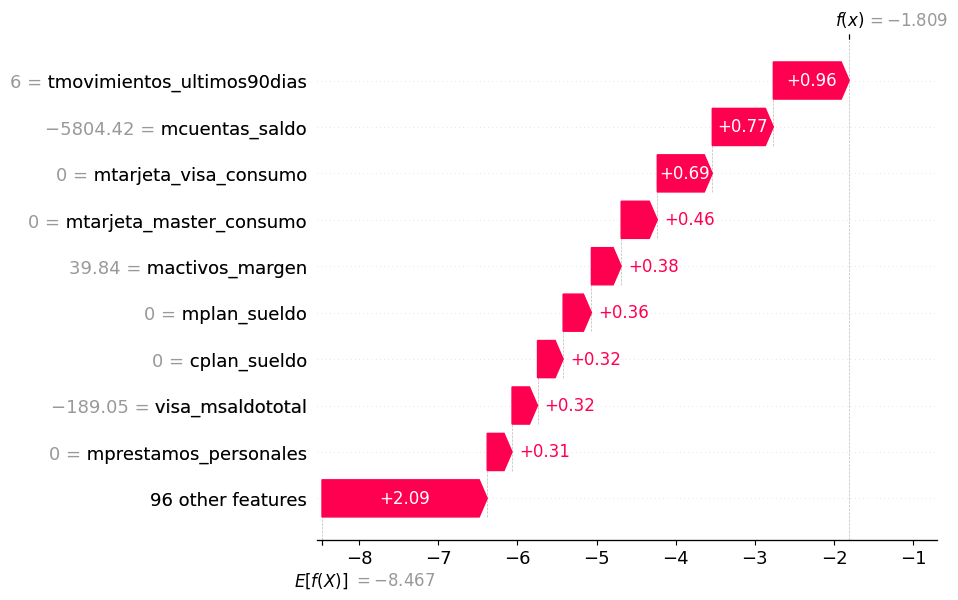

[FN 6] idx=49386 | f(x)=-1.637 → p=0.163 | true=1 pred=0


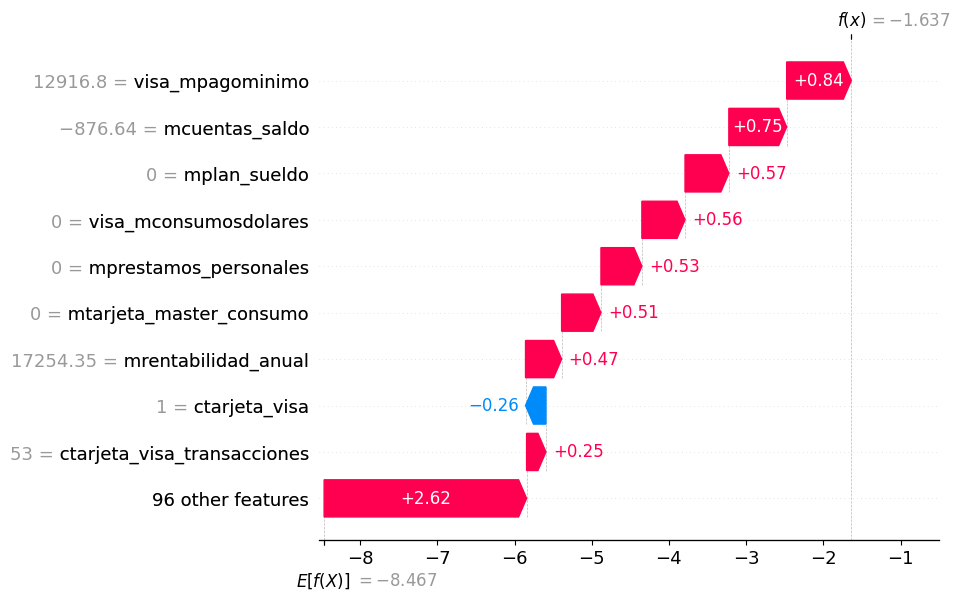

[FN 7] idx=114402 | f(x)=-0.470 → p=0.385 | true=1 pred=0


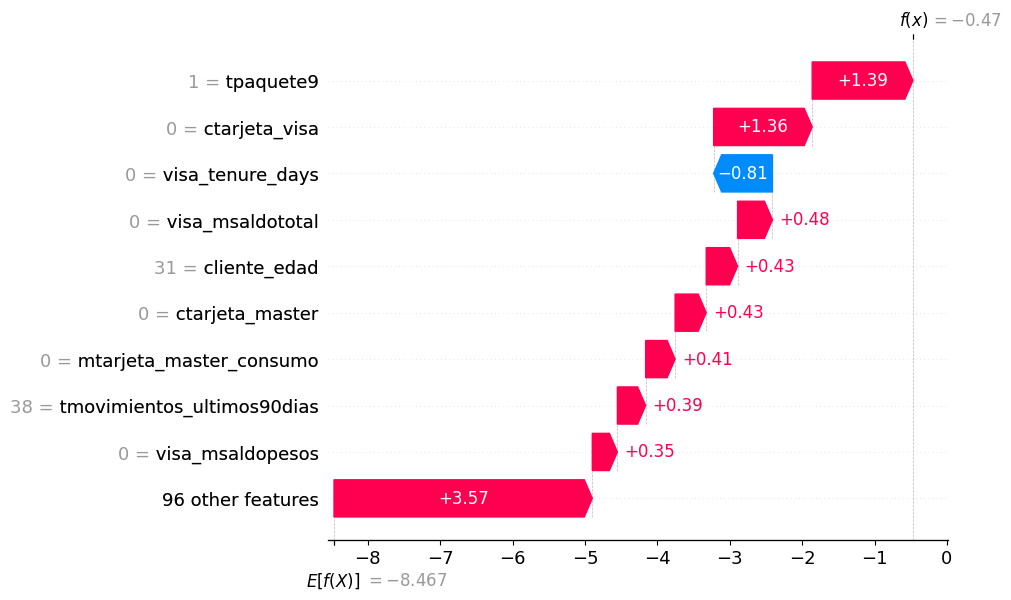

[FN 8] idx=4560 | f(x)=-0.977 → p=0.273 | true=1 pred=0


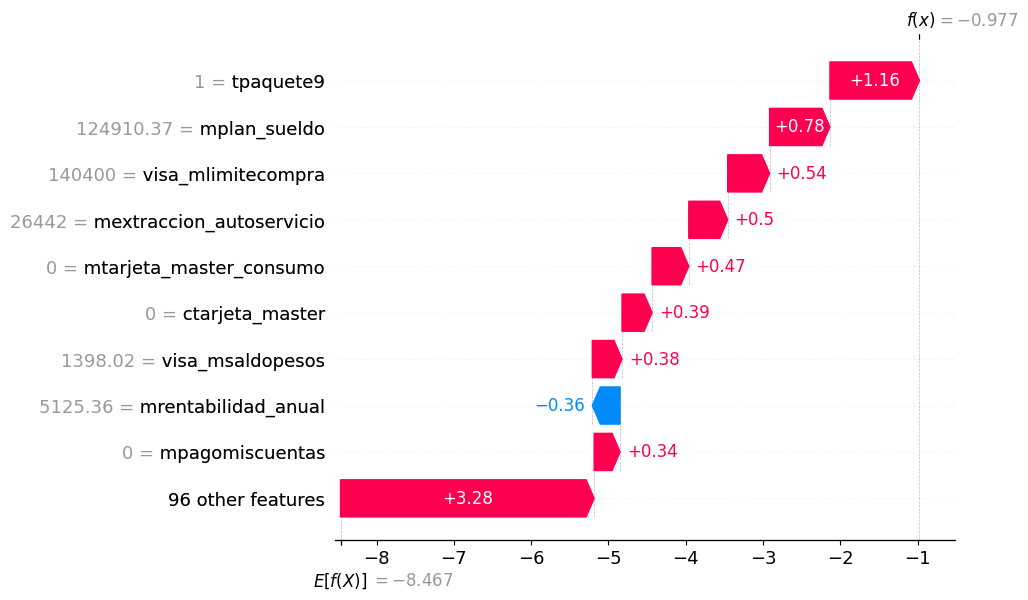

[FN 9] idx=112453 | f(x)=-3.368 → p=0.033 | true=1 pred=0


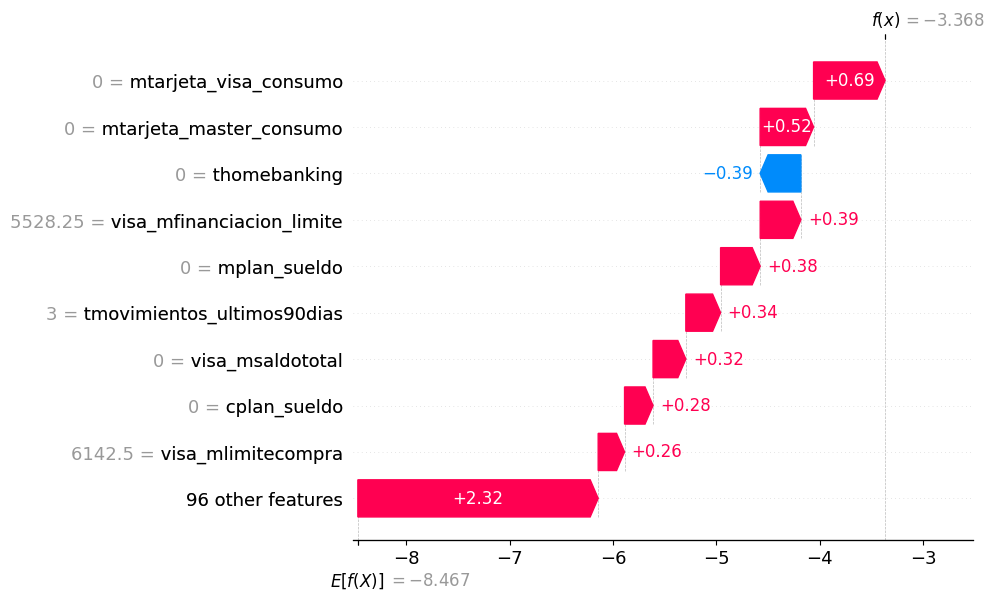

[FN 10] idx=140725 | f(x)=-0.539 → p=0.368 | true=1 pred=0


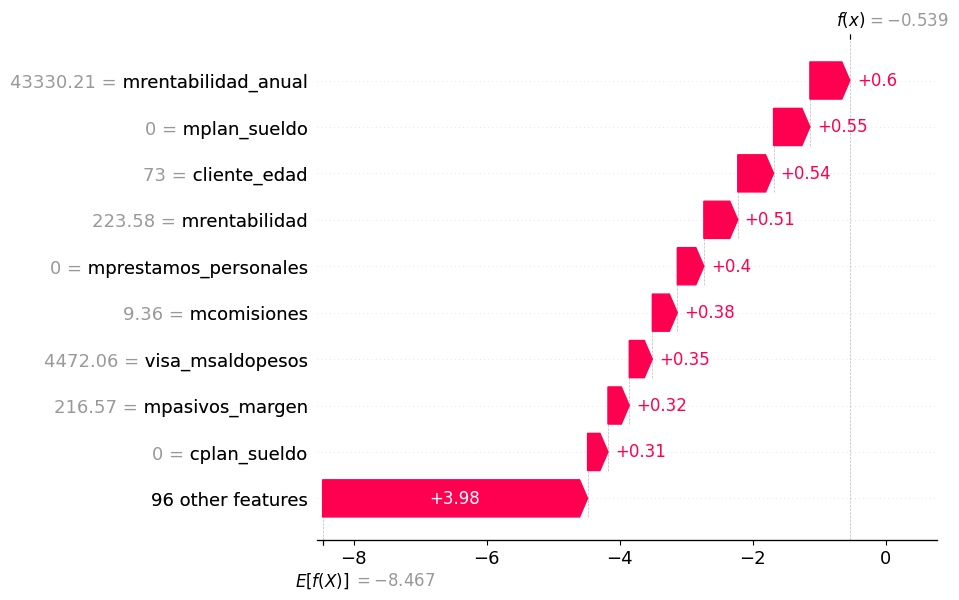

In [ ]:
for k, idx in enumerate(fn_idx, 1):
    # Reconstruct f(x) and probability (nice to print under each plot)
    fx = float(sv_all.base_values[idx] + sv_all.values[idx].sum())
    p  = 1.0 / (1.0 + math.exp(-fx))

    print(f"[FN {k}] idx={idx} | f(x) = {fx:.3f} → p = {p:.3f} | true = 1 pred = 0")
    shap.waterfall_plot(sv_all[idx], max_display = 10, show = True)

FN waterfalls — 10 missed churners (same baseline). In every case the bars sum to a negative f(x) (≈ –3.4 to –0.5) → model predicted non-churn.

Key Drivers:

* Common blue pulls (stabilizers): payroll/salary link, a loan, assets, regular debit/self-service use, longer tenure.
* Common red pushes (risk): low/negative balances, high card use/min payments/limits, fees/profitability, recent activity bursts; the “96 other features” block often adds a positive push.
* Why they’re missed: the stabilizers outweigh the risk signals; many scores are close to 0 (borderline).
* Fixes: add recent-change features and use a lower/segment-specific threshold to boost recall on these profiles.

Many of our False Negatives have f(x) just below zero (e.g., –0.47, –0.54, –0.98), which means the model was uncertain and barely predicted non-churn. These are good candidates to recover by lowering the decision threshold or using cost-sensitive tuning. A few FNs have large negative f(x) (e.g., –3.37), indicating confident but wrong predictions—those likely need new/change features (recent drops in balance/usage, new fees/late flags) rather than a threshold tweak.